# Seizure detection sandbox

## Workspace Preparation

In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')


In [2]:
plt.rcParams['image.cmap'] = 'magma'

In [3]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
figpath = CONFIG["paths"]["FIGURES"]
patient_table = pd.DataFrame(CONFIG["patients"]).sort_values('ptID')
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = patient_table.ptID.to_numpy()

In [4]:
set_seed(5210)

In [5]:
pt = 'HUP097'

## Defining Model Architectures

## Pulling Ictal Data

In [7]:
 # Defining paths for saved data
raw_datapath = ospj(datapath,pt)
if not os.path.exists(ospj(raw_datapath, "seizures")):
    os.makedirs(ospj(raw_datapath, "seizures"))

In [11]:
# access iEEG
with open('woj_ieeglogin.bin', 'r') as f:
  session = Session('wojemann', f.read())
ds = session.open_dataset(f'{pt}_phaseII')
# get labels and time series info
raw_labels = ds.get_channel_labels()
clean_labels = clean_labels(raw_labels,pt)
chn_labels = [l for l in clean_labels if l not in ['Cz','Fz','C03','C04','F04','F08','Fp02','O01','P04','T04','T06','EKG01','EKG02','ROC','LOC']]

timeseries = ds.get_time_series_details(raw_labels[0])

#get the sampling frequency
fs = timeseries.sample_rate

### Code for saving and preprocessing

In [43]:
def preprocess_presave(data,fs,montage='bipolar',factor=4):
    chs = data.columns.to_list()
    ch_df = check_channel_types(chs)
    # Montage
    if montage == 'bipolar':
        data_bp_np,bp_ch_df = bipolar_montage(data.to_numpy().T,ch_df)
        bp_ch = bp_ch_df.name.to_numpy()
    elif montage == 'car':
        data_bp_np = (data.to_numpy().T - np.mean(data.to_numpy(),1))
        bp_ch = chs
    # mask,_ = detect_bad_channels(data_bp_np.T,fs)
    # Bandpass filtering
    data_bp_filt = notch_filter(data_bp_np,fs)
    data_bp_filt = bandpass_filter(data_bp_filt,fs,hi=100)
    # Down sampling
    data_bpd = sc.signal.decimate(data_bp_filt,factor).T
    fsd = fs/factor
    data_white = ar_one(data_bpd)
    data_white_df = pd.DataFrame(data_white,columns = bp_ch)
    return data_white_df,fsd

## Training Unsupervised Models

### Code for saving and preprocessing

In [52]:
print(f"Saving interictal training data")
montage='car'
INTERTIME = 127215
pt_ieeg = f'{pt}_phaseII'
inter,fs = get_iEEG_data(usr,passpath,
                            pt_ieeg,
                            INTERTIME*1e6,
                            (INTERTIME+10)*1e6,
                            chn_labels,
                            force_pull = True)

inter_prep,fsd = preprocess_presave(inter,fs,montage,factor=2)
inter_prep.to_pickle(ospj(raw_datapath,"seizures",f"det{int(fsd)}_interictal_{montage}.pkl"))

Saving interictal training data


In [83]:
print(f"Saving interictal testing data")
montage='car'
INTERTIME = 816807
pt_ieeg = f'{pt}_phaseII'
inter,fs = get_iEEG_data(usr,passpath,
                            pt_ieeg,
                            INTERTIME*1e6,
                            (INTERTIME+60)*1e6,
                            chn_labels,
                            force_pull = True)

inter_prep,fsd = preprocess_presave(inter,fs,montage,factor=2)
inter_prep.to_pickle(ospj(raw_datapath,"seizures",f"det{int(fsd)}_test_{montage}.pkl"))

Saving interictal testing data


### Code for data formatting and training

#### data formatting

In [84]:
def prepare_segment(data, fs = 256,train_win = 12, pred_win = 1, w_size = 1, w_stride=0.5,ret_time=False):
    data_ch = data.columns.to_list()
    data_np = data.to_numpy()
    train_win = 12
    pred_win = 1
    j = fs-(train_win+pred_win)+1
    nwins = num_wins(len(data_np[:,0]),fs,w_size,w_stride)
    data_mat = torch.zeros((nwins,j,(train_win+pred_win),len(data_ch)))
    for k in range(len(data_ch)): # Iterating through channels
        samples = MovingWinClips(data_np[:,k],fs,1,0.5)
        for i in range(samples.shape[0]):
            clip = samples[i,:]
            mat = torch.tensor(hankel(clip[:j],clip[-(train_win+pred_win):]))
            data_mat[i,:,:,k] = mat
    time_mat = MovingWinClips(np.arange(len(data))/fs,fs,1,0.5)
    win_times = time_mat[:,0]
    data_flat = data_mat.reshape((-1,train_win + pred_win,len(data_ch)))
    input_data = data_flat[:,:-1,:].float()
    target_data = data_flat[:,-1,:].float()
    if ret_time:
        return input_data, target_data, win_times
    else:
        return input_data, target_data

In [85]:
def predict_sz(model, input_data, target_data,batch_size=1):
    dataset = TensorDataset(input_data,target_data)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in tqdm(dataloader):
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            mse = (outputs-targets)**2
            mse_distribution.append(mse)
    return torch.cat(mse_distribution).cpu().numpy()

In [86]:
def repair_data(outputs,data,fs=256,train_win=12,pred_win=1,w_size=1,w_stride=.5):
    nwins = num_wins(len(data),fs,w_size,w_stride)
    nchannels = data.shape[1]
    repaired = outputs.reshape((nwins,fs-(train_win + pred_win)+1,nchannels))
    return repaired

#### preparing training

In [87]:
fs = 250
inter = pd.read_pickle(ospj(raw_datapath,"seizures",f"det{fs}_interictal_{montage}.pkl"))
test = pd.read_pickle(ospj(raw_datapath,"seizures",f"det{fs}_test_{montage}.pkl"))

In [88]:
# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter)

dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the model
input_size = input_data.shape[2]
hidden_size = 10
output_size = input_data.shape[2]

In [89]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1,:])
        return out
    
class LRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Flatten the input along the 'sequence length' dimension
        x = x.squeeze()
        out = self.linear(x)
        return out


#### model initialization and training

In [90]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, output_size)
print(model)
ccheck = torch.cuda.is_available()
if ccheck:
   model.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

LSTMModel(
  (lstm): LSTM(100, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=100, bias=True)
)


In [91]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        if ccheck:
            inputs = inputs.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 9:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 154.1055
Epoch [20/100], Loss: 136.0154
Epoch [30/100], Loss: 122.8391
Epoch [40/100], Loss: 113.4191
Epoch [50/100], Loss: 107.1435
Epoch [60/100], Loss: 106.6352
Epoch [70/100], Loss: 105.9202
Epoch [80/100], Loss: 102.7451
Epoch [90/100], Loss: 102.3715
Epoch [100/100], Loss: 100.1885


#### determining detection threshold

In [92]:
input_data,target_data = prepare_segment(inter)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=400)
thresholds = np.percentile(inter_outputs,95,0)

100%|██████████| 11/11 [00:00<00:00, 214.85it/s]


## Seizure Detection

### Generating probability heatmaps

In [93]:
def scale_normalized(data,m=5):
    # takes in data and returns a flattened array with outliers removed based on distribution of entire tensor
    data_flat = data.flatten()
    d = np.abs(data_flat - np.median(data_flat))
    mdev = np.median(d)
    s = d / mdev
    scaler = np.max(data_flat[s<m])
    data_norm = data/scaler
    data_norm[data_norm > 1] = 1
    return data_norm

In [94]:
train_win = 12
pred_win = 1
input_data, target_data, win_times = prepare_segment(test,fs,train_win,pred_win,ret_time=True)

In [95]:
outputs = predict_sz(model,input_data,target_data,400)
test_mat = repair_data(outputs,test,fs)

100%|██████████| 71/71 [00:00<00:00, 229.89it/s]


In [104]:
# Getting raw predicted loss values for each window
raw_test_vals = np.median(test_mat,1).T
# # Creating classifications
# sz_clf = (raw_sz_vals.T > np.log(thresholds)).T
# # Dropping channels with too many positive detections (bad channels)
# # This should be replaced with actual channel rejection
# rejection_mask = np.sum(sz_clf,axis=1) > (sz_clf.shape[1]*3/5)
# sz_clf[rejection_mask,:] = 0 # fake channel rejection
# sz_clf[~mask,:] = 0 # real channel rejection

# # Normalizing values of the loss
# norm_sz_vals = scale_normalized(np.mean(np.log(seizure_mat),1).T)
# # Creating smoothed sz values
# sz_vals = sc.ndimage.uniform_filter1d(raw_sz_vals,10,axis=1)
# # Creating probabilities by temporally smoothing classification
# sz_prob = sc.ndimage.uniform_filter1d(sz_clf.astype(float),10,axis=1)
# # Sorting channels based on probability at sz onset
# first_detect = np.argmax(sz_prob[:,115:]>.5,axis=1)
# first_detect[first_detect == 0] = sz_prob.shape[1]
# ch_sorting = np.argsort(first_detect)

# # rejecting noisy/late channels
# bottom_mask = np.sum(sz_clf[ch_sorting,:],axis=1) > 0
# first_zero = np.where(~bottom_mask)[0][0].astype(int)
# sz_clf[ch_sorting[first_zero:],:] = 0
# sz_prob[ch_sorting[first_zero:],:] = 0
# # sz_vals[ch_sorting[first_zero:],:] = 0

### Plotting seizure detection pipeline

([<matplotlib.axis.XTick at 0x7efda869d4e0>,
 [Text(0, 0, '-60.0'),
  Text(10, 0, '-55.0'),
  Text(20, 0, '-50.0'),
  Text(30, 0, '-45.0'),
  Text(40, 0, '-40.0'),
  Text(50, 0, '-35.0'),
  Text(60, 0, '-30.0'),
  Text(70, 0, '-25.0'),
  Text(80, 0, '-20.0'),
  Text(90, 0, '-15.0'),
  Text(100, 0, '-10.0'),
  Text(110, 0, '-5.0')])

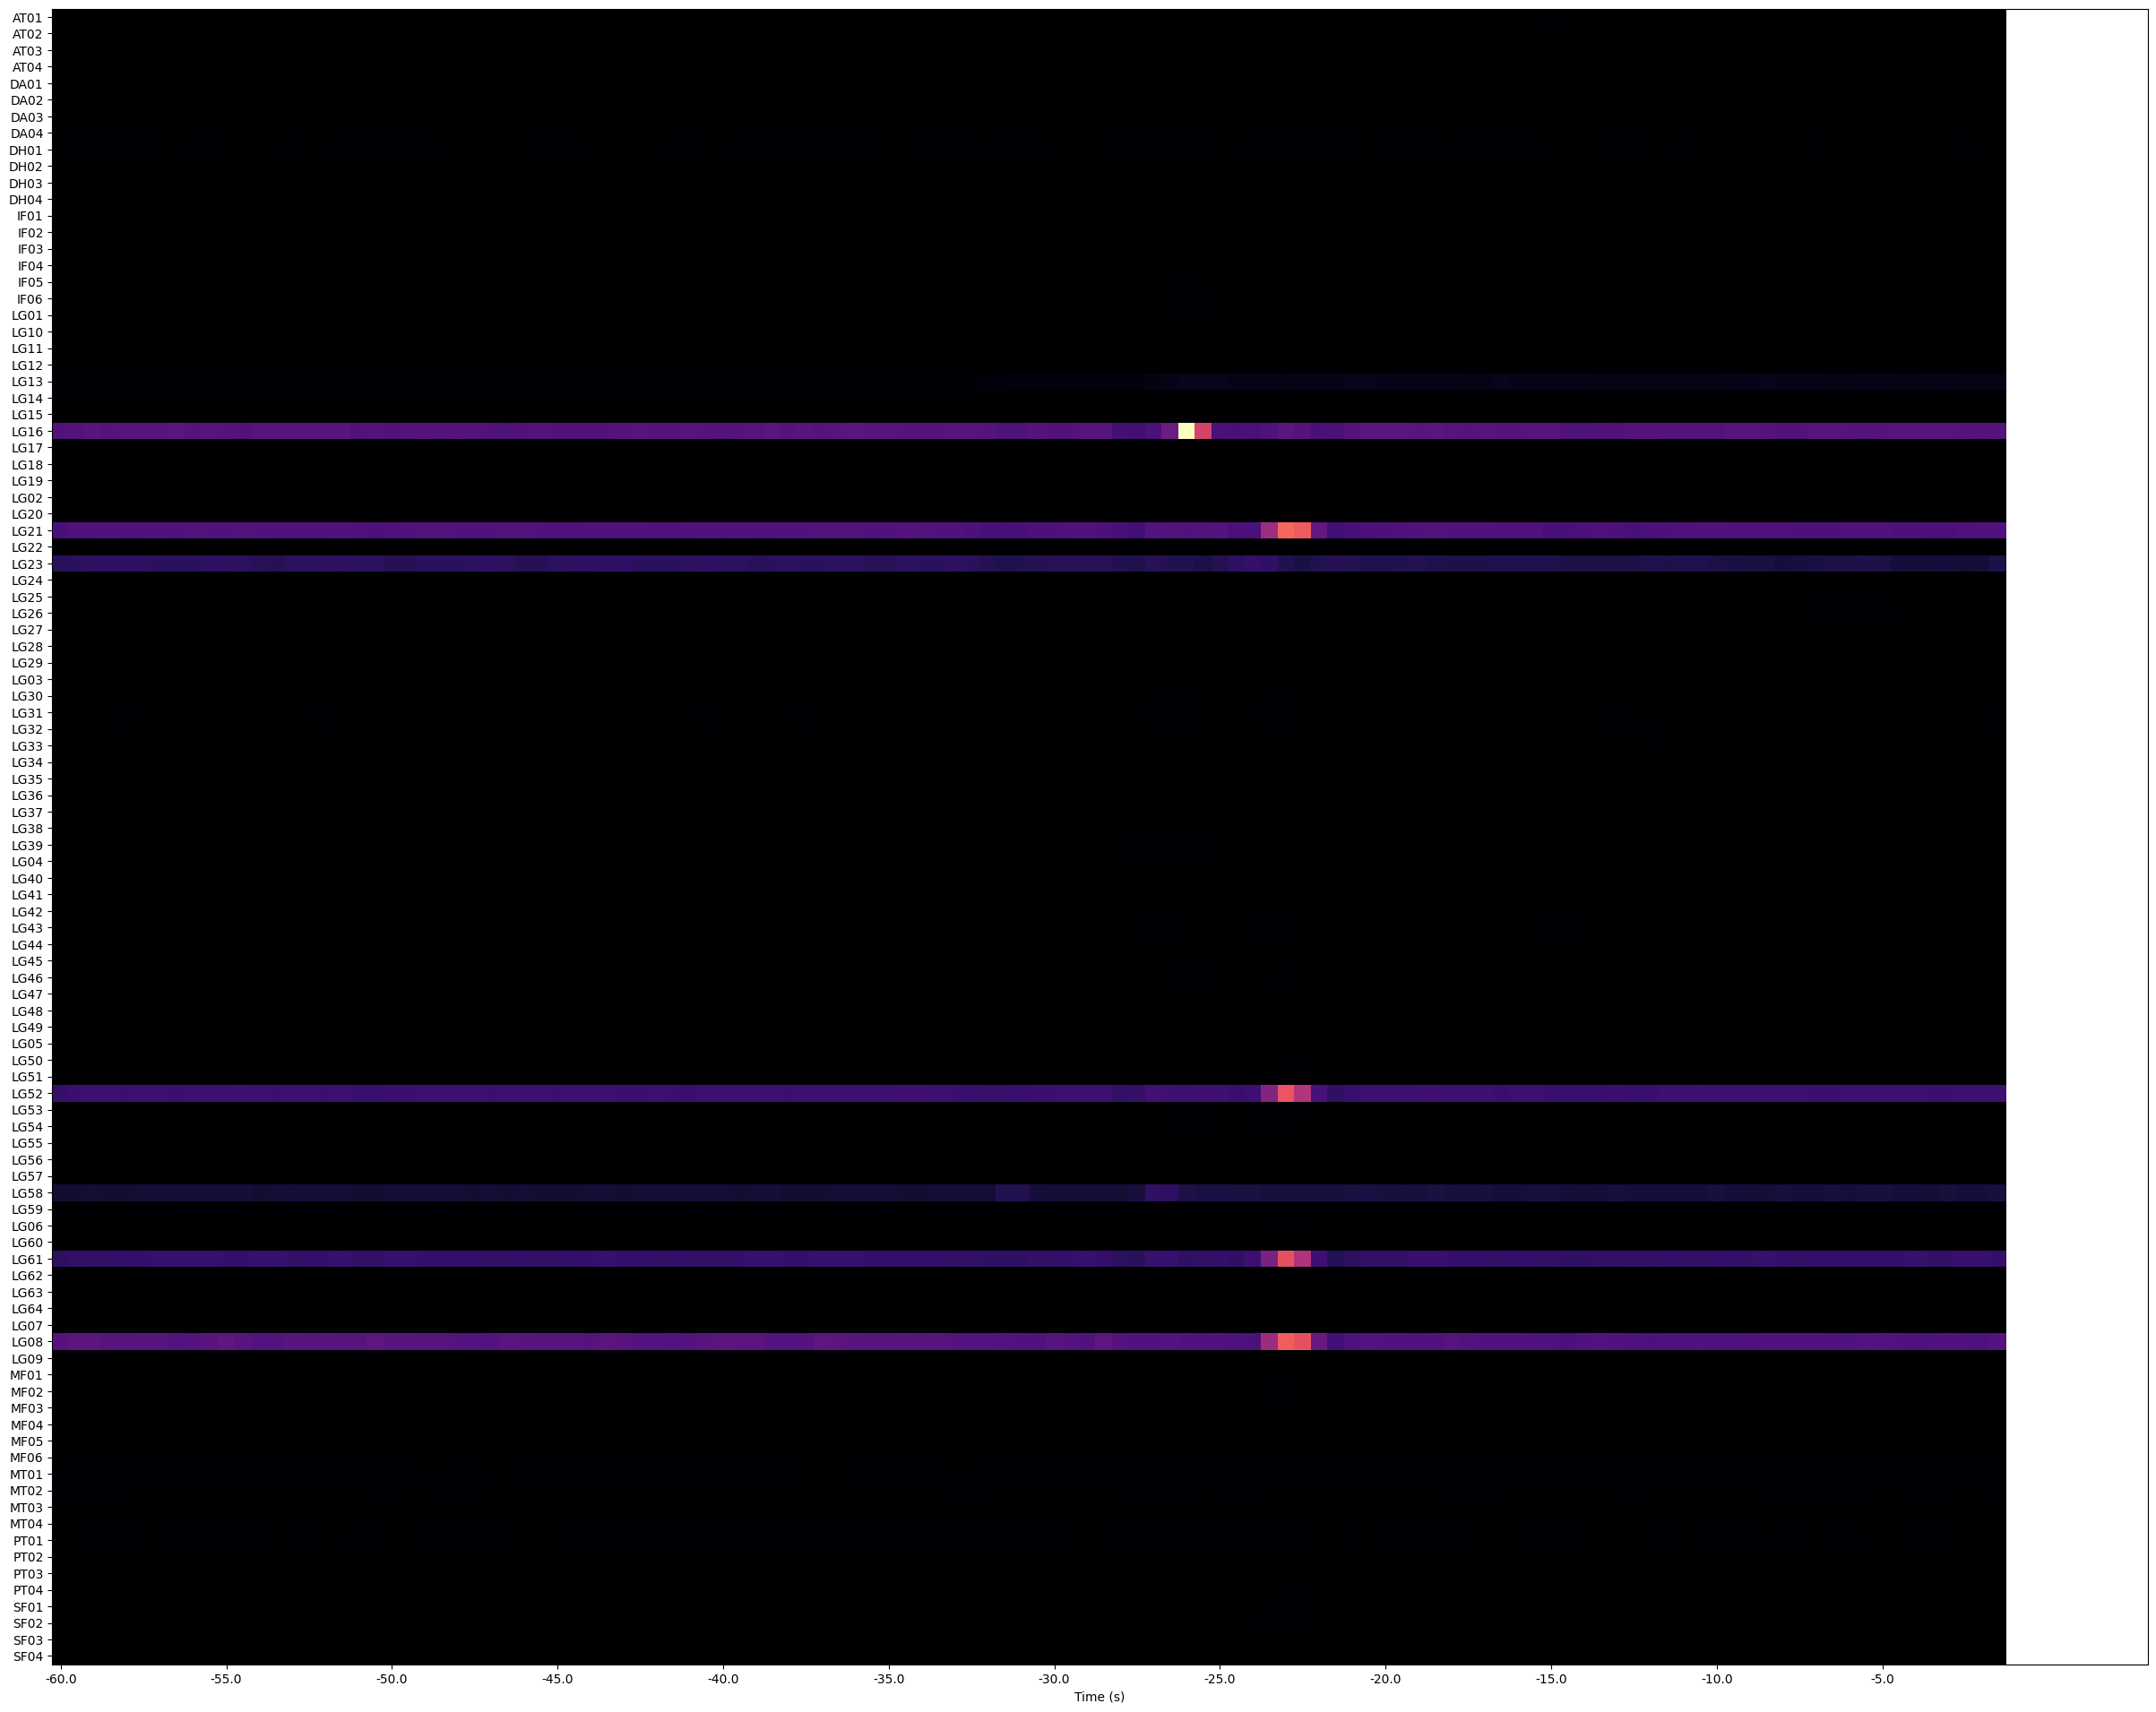

In [105]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(raw_test_vals)
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(test.shape[1]),test.columns,rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)] - 60)
# plt.colorbar()
# plt.xlim([115,400])


<Axes: >

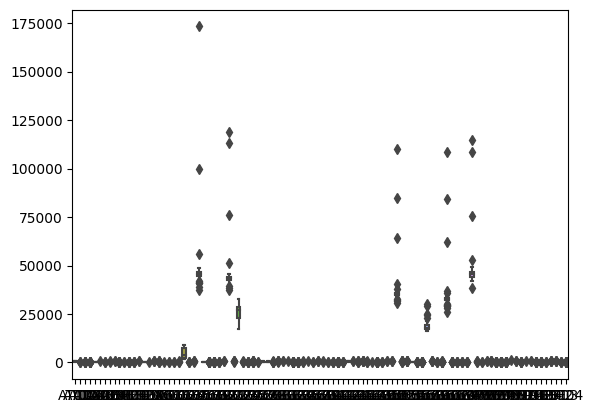

In [106]:

sns.boxplot(pd.DataFrame(raw_test_vals.T,columns=test.columns))

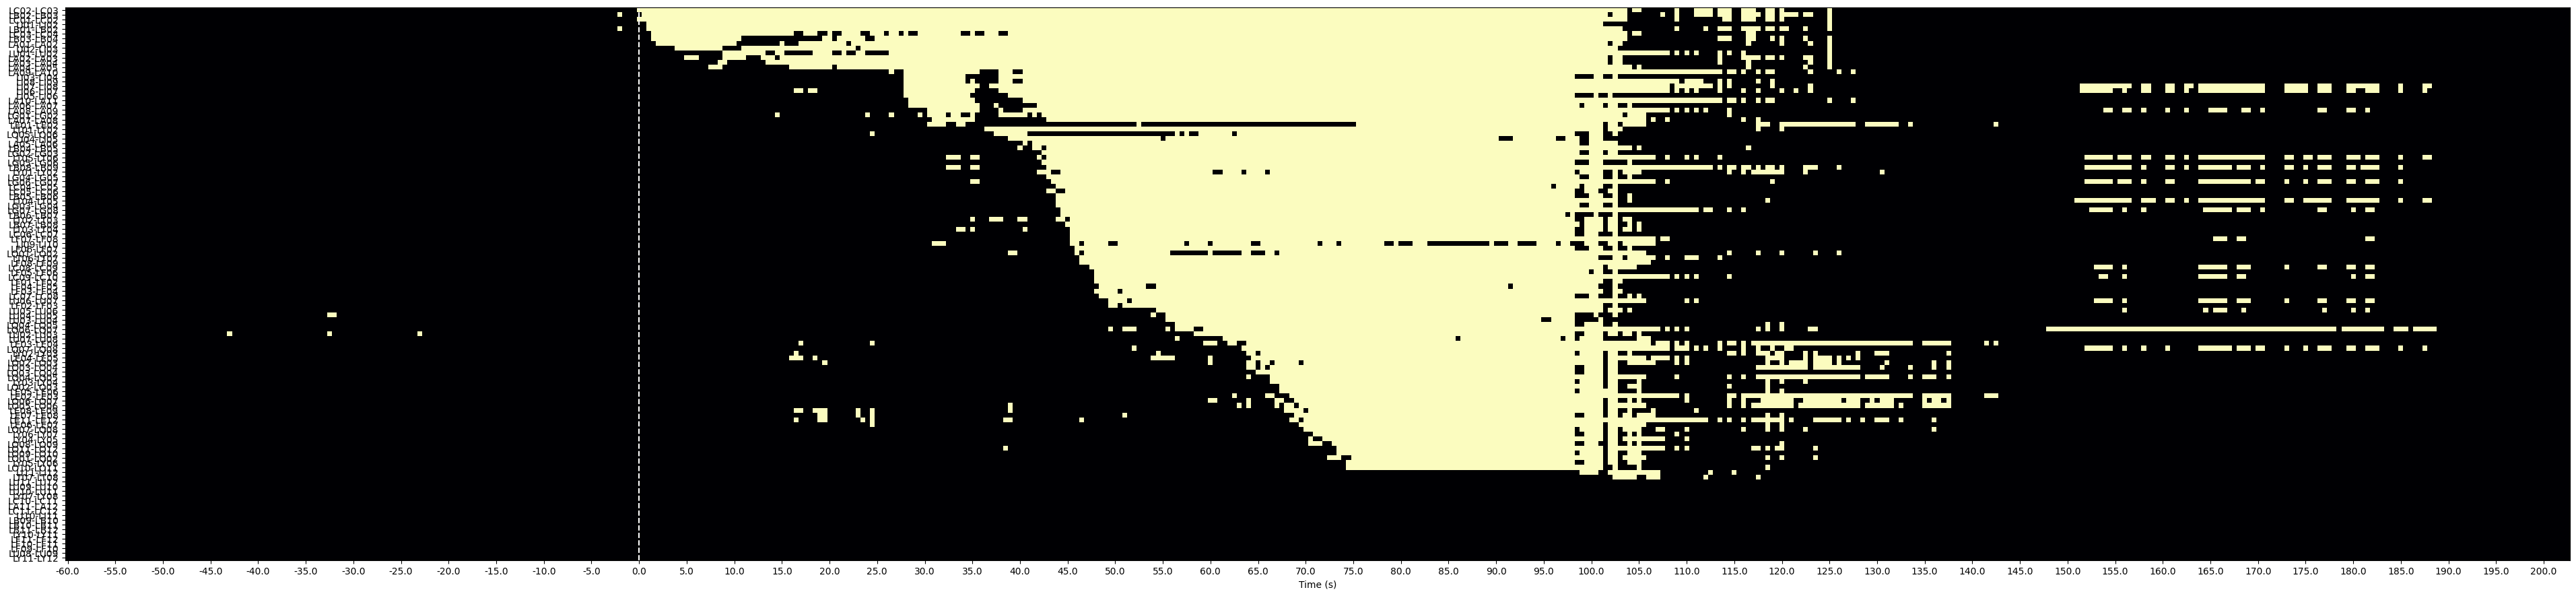

In [99]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_clf[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_vals.png'))

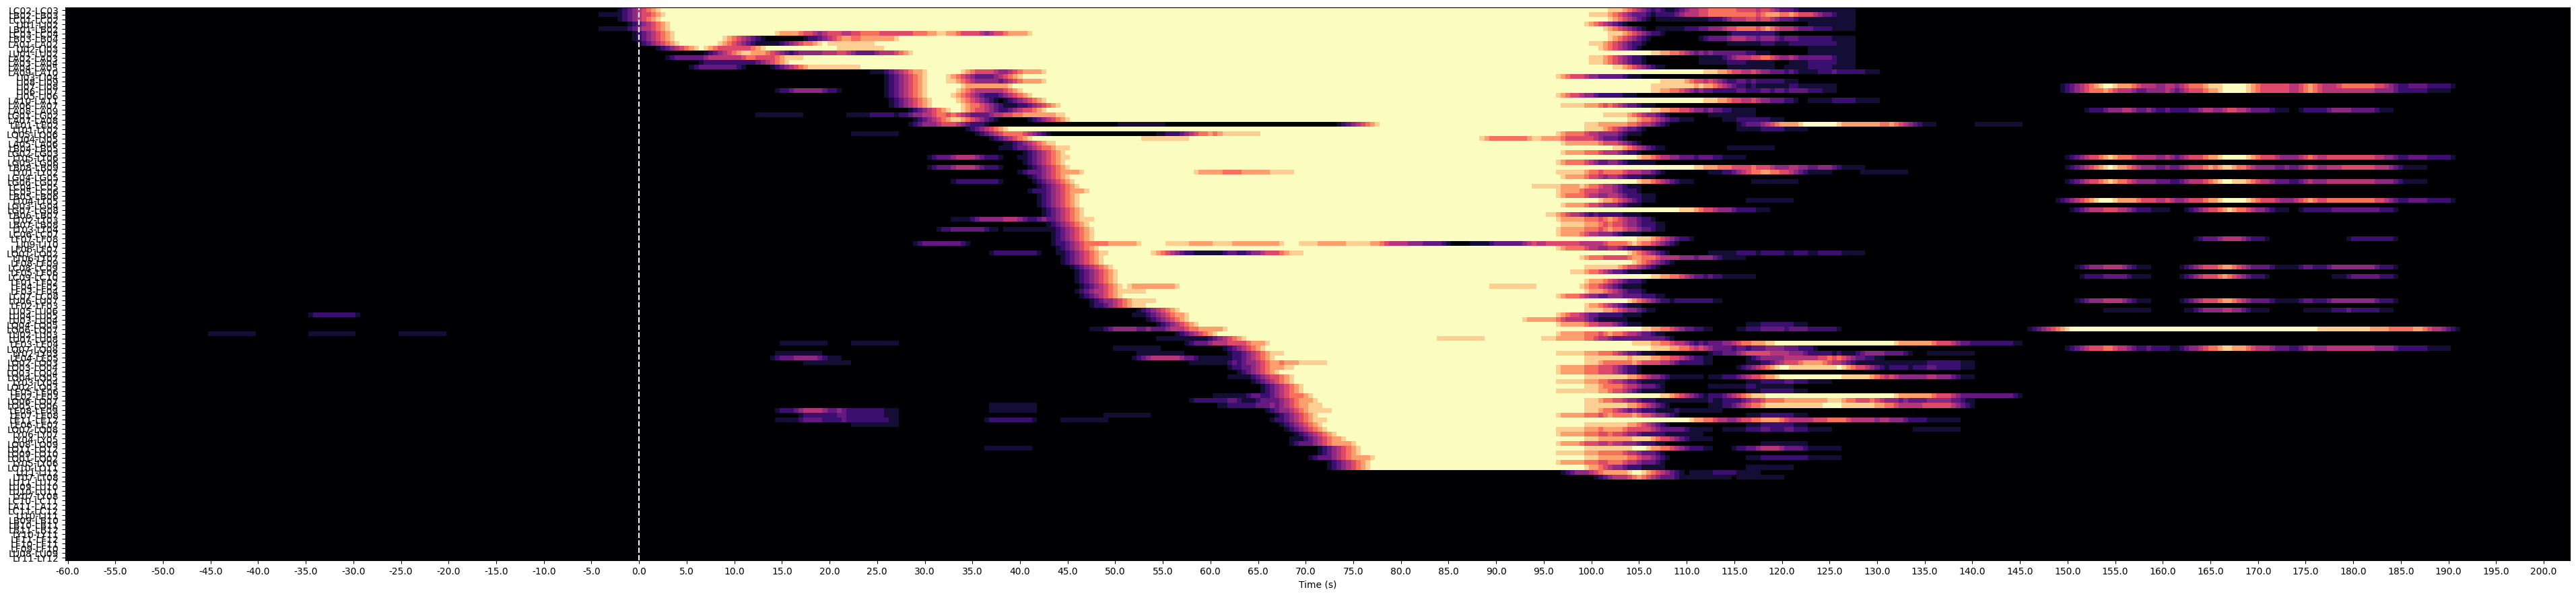

In [100]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_prob.png'))

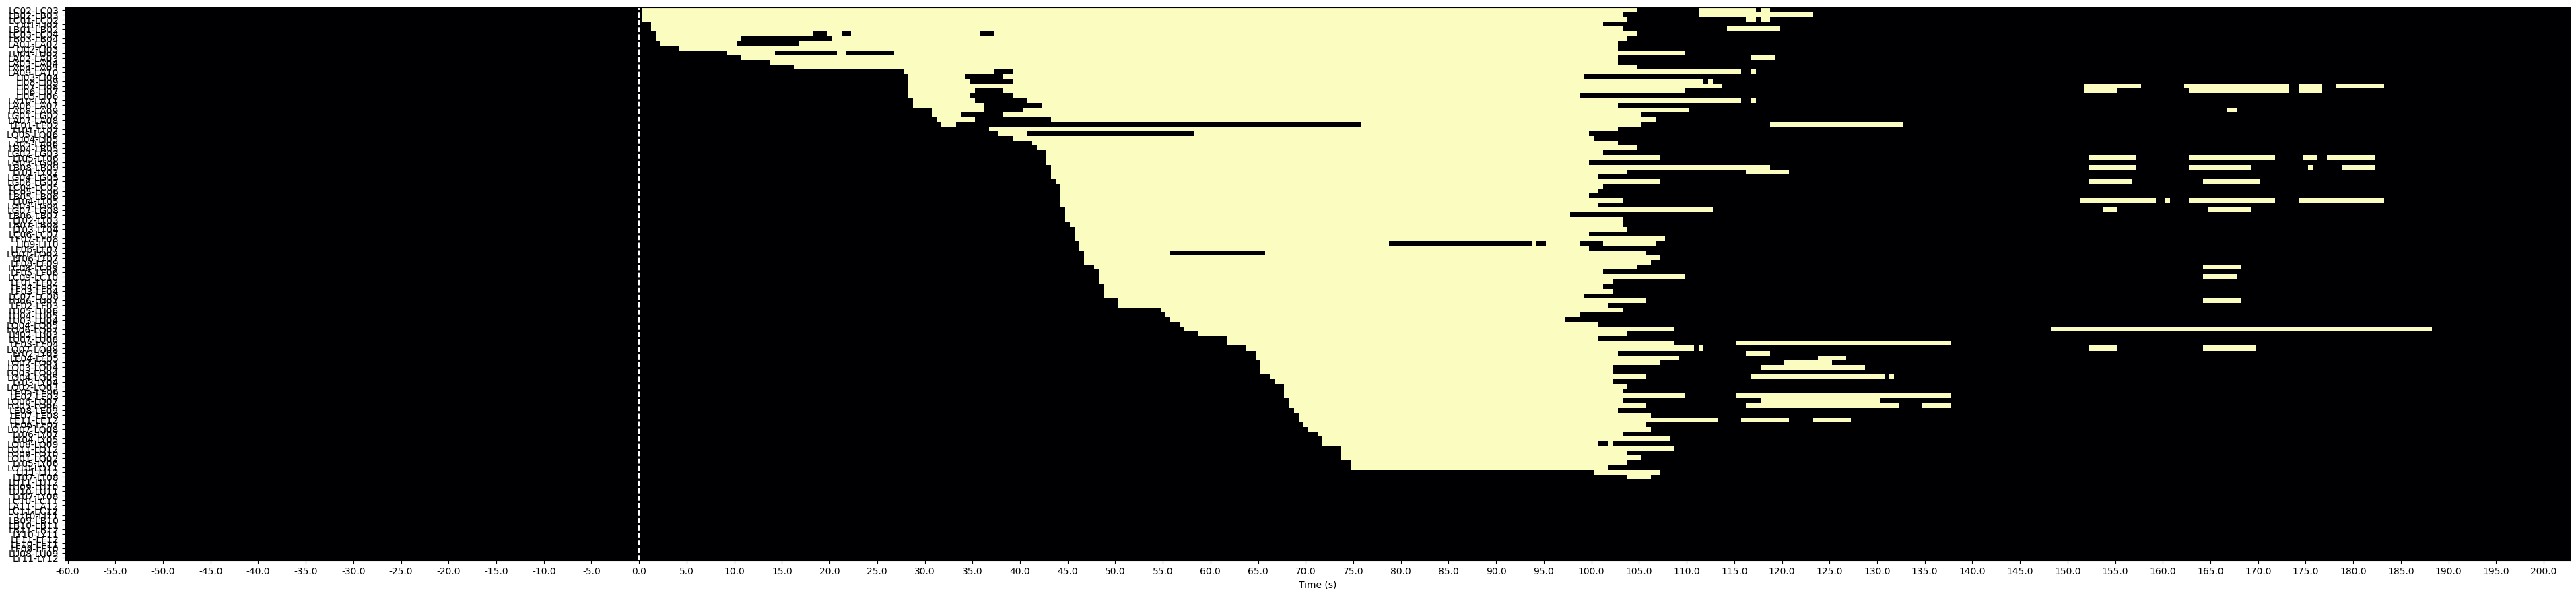

In [112]:
# Example threshold set to 0.6. Will find optimal threshold when we have 
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:]>.5)
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_classification.png'))

### Generating UEO predictions

In [116]:
sz_clf_final = sz_prob > 0.5
first_seizing_index = np.argmax(sz_clf_final.any(axis=0))
mdl_ueo_idx = np.where(np.sum(sz_clf_final[:, first_seizing_index:first_seizing_index + 3], axis=1) > 0)[0]
mdl_ueo_ch_bp = seizure.columns.to_numpy()[mdl_ueo_idx]
mdl_ueo_ch = [s.split("-")[0] for s in mdl_ueo_ch_bp]
mdl_ueo_ch

['LB01', 'LB02', 'LC01', 'LC02', 'LI01']

### Absolute Slope Null

In [104]:
scaler = RobustScaler().fit(inter)
ninter = scaler.transform(inter)
nseizure = scaler.transform(seizure)

In [105]:
base_stds = np.std(ninter,axis=0)
abs_slope = lambda x: np.mean(np.abs(np.diff(x,axis=-1)),axis=-1)
all_slopes = ft_extract(nseizure.T,fs,abs_slope,1,.5)
scaled_slopes = all_slopes.squeeze()/np.expand_dims(base_stds,1)*fs
# all_linlens = ft_extract(nseizure.T,fs,abs_slope,1,.5)/(0.5*fs)

In [106]:
# scaling linlen by the max value excluding outliers
all_linlens_norm = scale_normalized(scaled_slopes)
all_linlens_smoothed = sc.ndimage.uniform_filter1d(all_linlens_norm,10,axis=1)

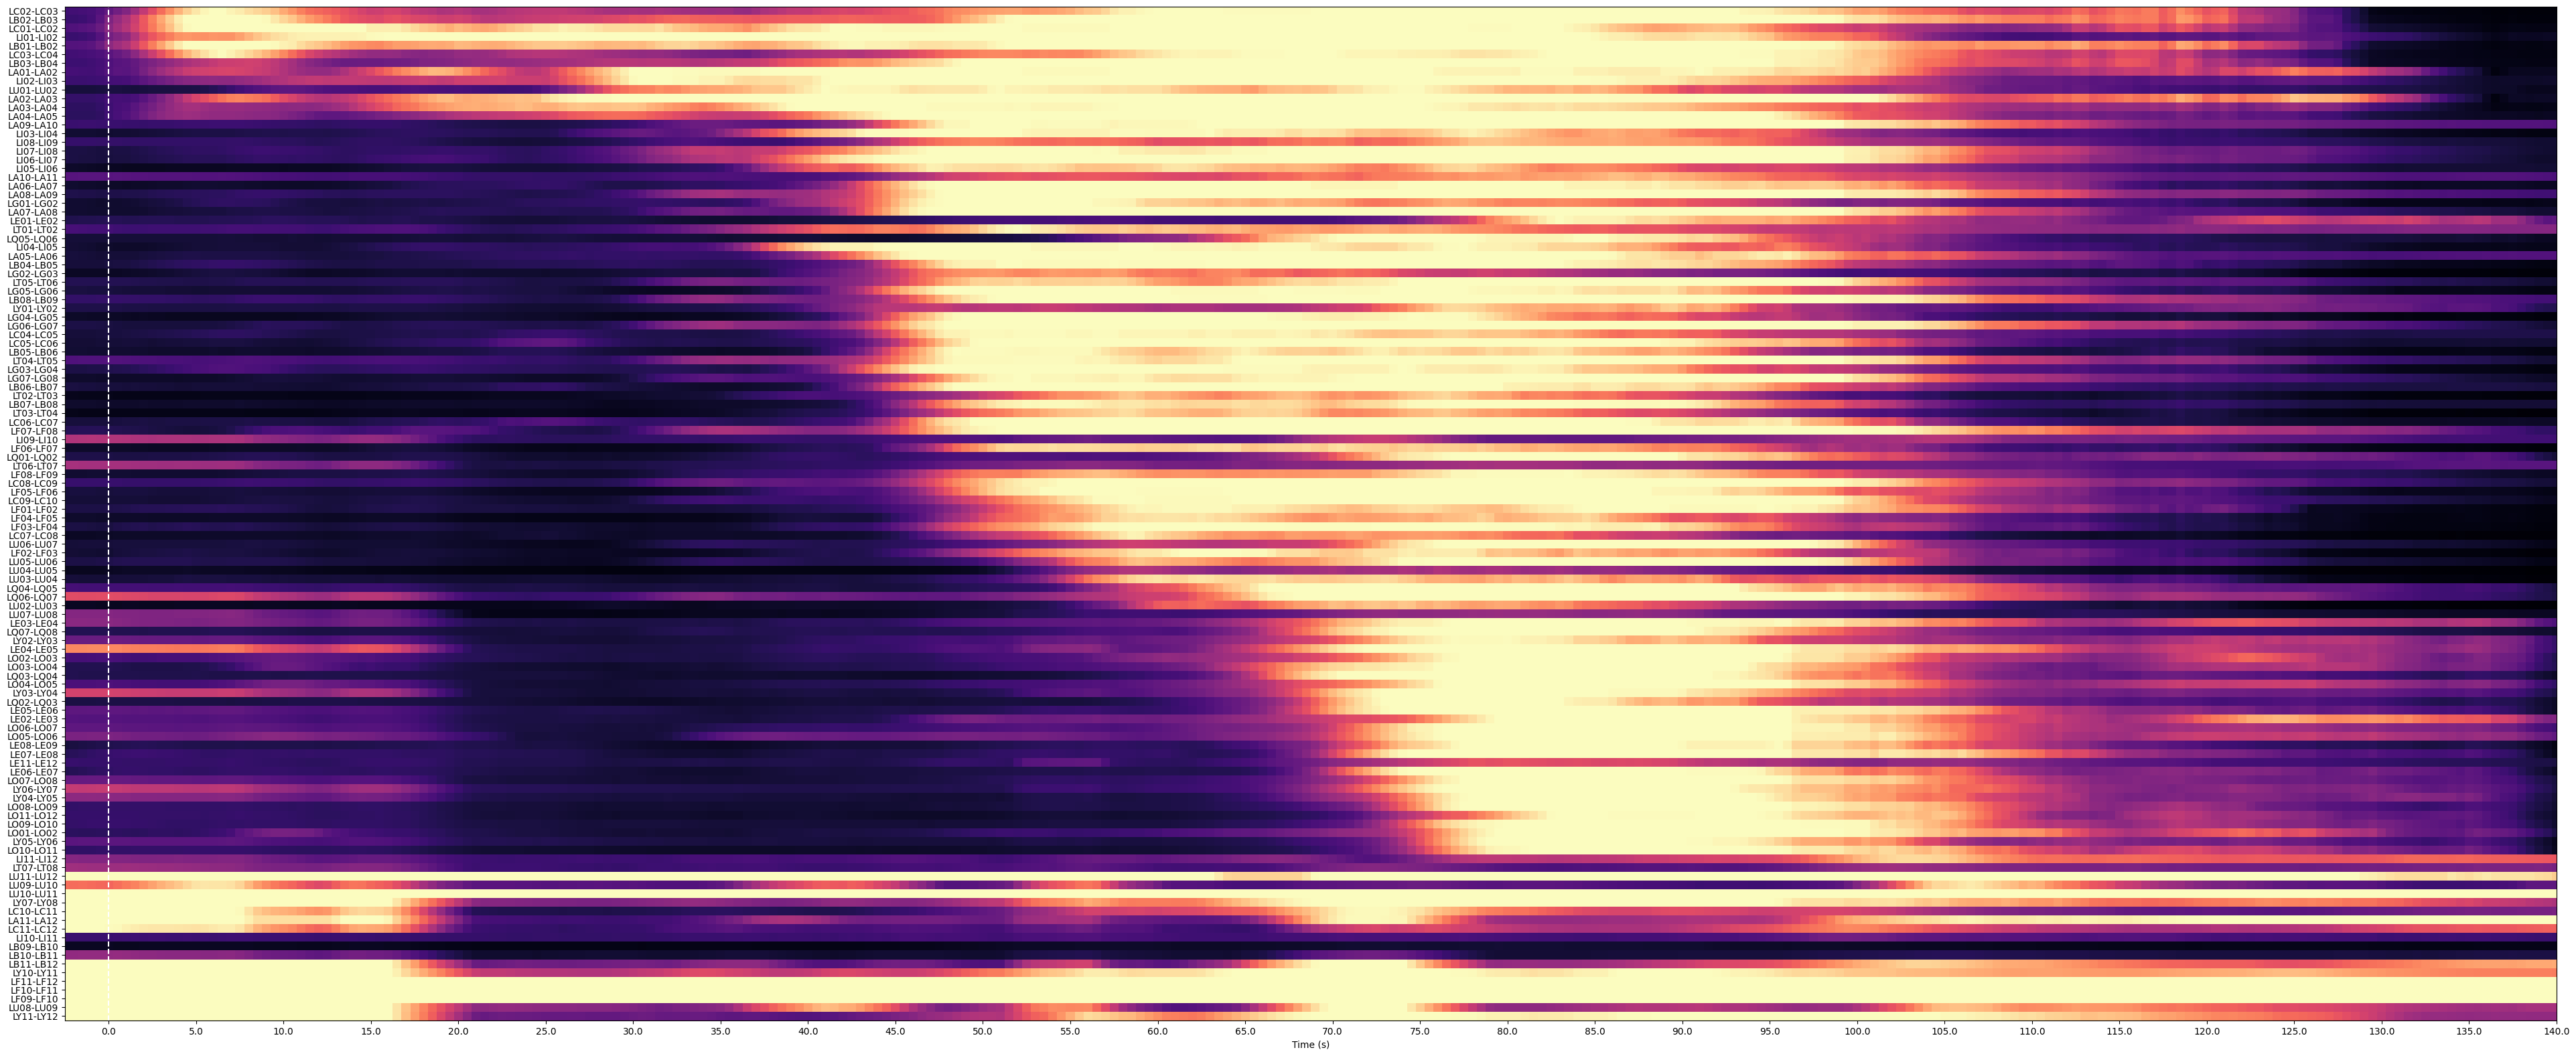

In [107]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(all_linlens_smoothed[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_null.png'))